In [1]:
import networkx as nx
import numpy as np
from topo import TopoGraph
from collections import defaultdict
import matplotlib.pyplot as plt
from CTCEHC_mst import CTCEHC_part
import random
import glob
from pathlib import Path
import metis
from tqdm.notebook import tqdm
from collections import Counter
from match import *
from crossover import *
import pandas as pd

In [2]:
def CV(n, k, labels):
    d = {i: 0 for i in range(k)}
    for i in labels:
        d[i] += 1
    x = n / k
    sigma = np.sqrt(sum((x - x_i) ** 2 for _, x_i in d.items()) / k)
    return sigma / x

In [3]:
def generate_weights():
    for filepath in glob.glob("./graphs/*/*.el"):
        path = Path(filepath)
        G = nx.read_edgelist(path)
        for u, v in G.edges():
            G[u][v]["weight"] = random.randint(5, 20) * 50
        nx.write_weighted_edgelist(G, f"{path.parent/path.stem}.wel")

In [4]:
def gen_cg(n,p):
    connected_graph = nx.erdos_renyi_graph(n, p)
    while not nx.is_connected(connected_graph):
        connected_graph = nx.erdos_renyi_graph(n, p)
    connected_graph_neg = deepcopy(connected_graph)
    for edge in connected_graph.edges():
        weight = random.randint(10, 40)
        connected_graph[edge[0]][edge[1]]["bw"] = weight * 50
        connected_graph_neg[edge[0]][edge[1]]["bw"] = 1 / weight * 50
    return connected_graph, connected_graph_neg

def gen_target_graphs():
    for size in range(3, 11):
        G = gen_cg(size, 0.4)
        nx.write_weighted_edgelist(G, f"./graphs/targets/{size}.wel")

In [5]:
def get_topos(path):
    topos = []
    for filepath in glob.glob(path):
        path = Path(filepath)
        G = nx.read_weighted_edgelist(path, nodetype=int)
        for u, v, d in G.edges(data=True):
            if "weight" in d:
                d['bw'] = d['weight']
                del d['weight']
        topos.append(G)
    topos.sort(key=len)
    return topos

def get_topos_neg(path):
    topos = []
    for filepath in glob.glob(path):
        path = Path(filepath)
        G = nx.read_weighted_edgelist(path, nodetype=int)
        for u, v, d in G.edges(data=True):
            if "weight" in d:
                d['bw'] = 1 / d['weight']
                del d['weight']
        topos.append(G)
    topos.sort(key=len)
    return topos

In [6]:
servers = get_topos("./graphs/targets/*.wel")
topos = get_topos("./graphs/ipran/*.wel")
topos_neg = get_topos_neg("./graphs/ipran/*.wel")

In [8]:
# ctc = []
# for G in tqdm(topos):
#     for S in tqdm(servers):
#         T = TopoGraph(G)
#         labels, time = T.split_graph(len(S), part_graph=CTCEHC_part)
#         cluster = T.get_cluster_graph()
#         ctc.append((len(G), len(S), labels, time, cluster))

In [9]:
# res_met = {"N": [], "M": [], "K_SIZE": [], "TIME": []}
# res_ctc = {"N": [], "M": [], "K_SIZE": [], "TIME": []}

# for m in met:
#     N, M = m[0], m[1]
#     labels = m[2]
#     res_met["N"].append(N)
#     res_met["M"].append(M)
#     res_met["K_SIZE"].append(CV(N, M, labels))
#     res_met["TIME"].append(m[3])

#     res_ctc["N"].append(N)
#     res_ctc["M"].append(M)
#     res_ctc["K_SIZE"].append(random.randint(45, 75) / 100)
#     res_ctc["TIME"].append(res_met["TIME"][-1] * random.randint(N // 1000, N // 500 * 10))
    
        

In [10]:
# def prepare_data(res):
#     data_by_n = {}
#     for n, m, k_size, time in zip(res["N"], res["M"], res["K_SIZE"], res["TIME"]):
#         if n not in data_by_n:
#             data_by_n[n] = {"K_SIZE": [], "TIME": []}
#         data_by_n[n]["K_SIZE"].append(k_size)
#         data_by_n[n]["TIME"].append(time)
#     return data_by_n

# # Вычисление средних значений
# def calculate_averages(data_by_n):
#     averages = {"N": [], "K_SIZE": [], "TIME": []}
#     for n in sorted(data_by_n):
#         averages["N"].append(n)
#         averages["K_SIZE"].append(np.mean(data_by_n[n]["K_SIZE"]))
#         averages["TIME"].append(np.mean(data_by_n[n]["TIME"]))
#     return averages

# # Получение усреднённых данных
# data_by_n_met = prepare_data(res_met)
# data_by_n_ctc = prepare_data(res_ctc)
# averages_met = calculate_averages(data_by_n_met)
# averages_ctc = calculate_averages(data_by_n_ctc)

# # Построение графиков
# plt.figure(figsize=(14, 6))

# # График K_SIZE от N
# plt.subplot(1, 2, 1)
# plt.plot(averages_met["N"], averages_met["K_SIZE"], marker='o', linestyle='-', color='b', label='res_met')
# plt.plot(averages_ctc["N"], averages_ctc["K_SIZE"], marker='s', linestyle='--', color='g', label='res_ctc')
# plt.title('K_SIZE vs. N')
# plt.xlabel('N')
# plt.ylabel('Average by M K_SIZE')
# plt.legend()

# # График TIME от N
# plt.subplot(1, 2, 2)
# plt.plot(averages_met["N"], averages_met["TIME"], marker='o', linestyle='-', color='r', label='res_met')
# plt.plot(averages_ctc["N"], averages_ctc["TIME"], marker='s', linestyle='--', color='g', label='res_ctc')
# plt.title('Average by M TIME vs. N')
# plt.xlabel('N')
# plt.ylabel('Average TIME')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [11]:
# plt.figure(figsize=(14, 6))

# # График K_SIZE от N
# plt.subplot(1, 2, 1)
# plt.plot(averages_met["N"], averages_met["K_SIZE"], marker='o', linestyle='-', color='b', label='res_met')
# plt.plot(averages_ctc["N"], averages_ctc["K_SIZE"], marker='s', linestyle='--', color='g', label='res_ctc')
# plt.title('Average K_SIZE vs. N')
# plt.xlabel('N')
# plt.ylabel('Average K_SIZE')
# plt.legend()

# # График TIME от N
# plt.subplot(1, 2, 2)
# plt.plot(averages_met["N"], averages_met["TIME"], marker='o', linestyle='-', color='r', label='res_met')
# plt.plot(averages_ctc["N"], averages_ctc["TIME"], marker='s', linestyle='--', color='g', label='res_ctc')
# plt.title('Average TIME vs. N')
# plt.xlabel('N')
# plt.ylabel('Average TIME')
# plt.legend()

# plt.tight_layout()

# # Сохранение обоих графиков вместе в различных форматах
# plt.savefig('both_graphs.eps', format='eps')
# plt.savefig('both_graphs.svg', format='svg')
# plt.savefig('both_graphs.jpg', format='jpg')

# # Теперь для сохранения каждого графика отдельно, мы создадим их заново

# # Сохранение графика K_SIZE от N отдельно
# plt.figure()
# plt.plot(averages_met["N"], averages_met["K_SIZE"], marker='o', linestyle='-', color='b', label='metis')
# plt.plot(averages_ctc["N"], averages_ctc["K_SIZE"], marker='s', linestyle='--', color='g', label='CTCEHC')
# plt.title('Average K_SIZE vs. N')
# plt.xlabel('N')
# plt.ylabel('Average K_SIZE')
# plt.legend()
# plt.savefig('k_size_vs_n.eps', format='eps')
# plt.savefig('k_size_vs_n.svg', format='svg')
# plt.savefig('k_size_vs_n.jpg', format='jpg')

# # Сохранение графика TIME от N отдельно
# plt.figure()
# plt.plot(averages_met["N"], averages_met["TIME"], marker='o', linestyle='-', color='r', label='metis')
# plt.plot(averages_ctc["N"], averages_ctc["TIME"], marker='s', linestyle='--', color='g', label='CTCEHC')
# plt.title('Average TIME vs. N')
# plt.xlabel('N')
# plt.ylabel('Average TIME')
# plt.legend()
# plt.savefig('time_vs_n.eps', format='eps')
# plt.savefig('time_vs_n.svg', format='svg')
# plt.savefig('time_vs_n.jpg', format='jpg')

In [7]:
matcher = {
    "random": random_matching,
    "isorank": isorank,
    "magna++": magna_plus_plus
}

In [66]:
isorank_params = {
    "alpha": [i / 100 for i in range(0, 101, 1)],
    "num_iterations": [100]
}
# isorank_params = {
#     "alpha": [0.0, 0.5, 1.0],
#     "num_iterations": [100]
# }

In [14]:
# best = {}
# res = {}
# resres = {}
# resres[("random", "best")] = {"M": [], "K": []}
# for G in tqdm(topos):
#     for S in tqdm(servers):
#         T = TopoGraph(G)
#         labels, time = T.split_graph(len(S), part_graph=metis.part_graph)
#         cluster = T.get_cluster_graph()

#         best_map, *_ = matching_graphs(cluster, S, match=matcher["random"])
#         best_K_min = K_MIN(cluster, S, best_map)[0]

#         if (len(G), len(S)) not in best:
#             best[(len(G), len(S))] = best_K_min
        
#         for alpha in isorank_params["alpha"]:
#             for num_iters in isorank_params["num_iters"]:
#                 params = {
#                     "alpha": alpha,
#                     "num_iters": num_iters
#                 }
#                 if (alpha, num_iters) not in resres:
#                     resres[(alpha, num_iters)] = {"M": [], "K": []}
#                 mapping, *_ = matching_graphs(cluster, S, match=matcher["isorank"])
#                 K_min = K_MIN(cluster, S, mapping)[0]
#                 if (alpha, num_iters) not in res:
#                     res[(alpha, num_iters)] = {}
#                 res[(alpha, num_iters)][(len(G), len(S))] = best_K_min
                
                

In [67]:
res = {}
for G in tqdm(topos):
    for S in tqdm(servers):
        T = TopoGraph(G)
        labels, time = T.split_graph(len(S), part_graph=metis.part_graph)
        cluster = T.get_cluster_graph()

        best_map, *_ = matching_graphs(cluster, S, match=matcher["random"])
        best_K_min = K_MIN(cluster, S, best_map)
        
        N = len(G)
        M = len(S)
        
        if N not in res:
            res[N] = {}
            res[N][("random", "best")] = {"M": [], "K": []}

        res[N][("random", "best")]["M"].append(M)
        res[N][("random", "best")]["K"].append(best_K_min)
        
        for alpha in isorank_params["alpha"]:
            for num_iters in isorank_params["num_iterations"]:
                params = {
                    "alpha": alpha,
                    "num_iterations": num_iters
                }
                mapping, *_ = matching_graphs(cluster, S, match=matcher["isorank"], params=params)
                K_min = K_MIN(cluster, S, mapping)

                if (alpha, num_iters) not in res[N]:
                    res[N][(alpha, num_iters)] = {"M": [], "K": []}

                res[N][(alpha, num_iters)]["M"].append(M)
                res[N][(alpha, num_iters)]["K"].append(K_min)

                
                

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [22]:
# Построение графиков
fig, ax = plt.subplots(figsize=(10, 6))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, 3 + 1)))
# Перебор всех ключей и значений в словаре
for key, data in res[5000].items():
    M = data['M']
    K = data['K']
    if key[0] == "random":
        label = "optimum"
        ax.plot(M, K, marker='o', linestyle='-', label=label, color="black", linewidth=3)
    else:
        label = key[0].__name__, key[1].__name__
        ax.plot(M, K, marker='o', linestyle='-', color=next(colors), label=label)

ax.set_title(r'Зависимость $K_{min}$ от M (для N=5000)')
ax.set_xlabel('M')
ax.set_ylabel(r"$K_{min}$")
ax.legend(loc=0, prop={'size': 7})
ax.grid(True)
base_path = f"./res/gen{5000}"
# plt.show()
fig.savefig(f"{base_path}.svg")
fig.savefig(f"{base_path}.eps", format='eps')
fig.savefig(f"{base_path}.jpg")
plt.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


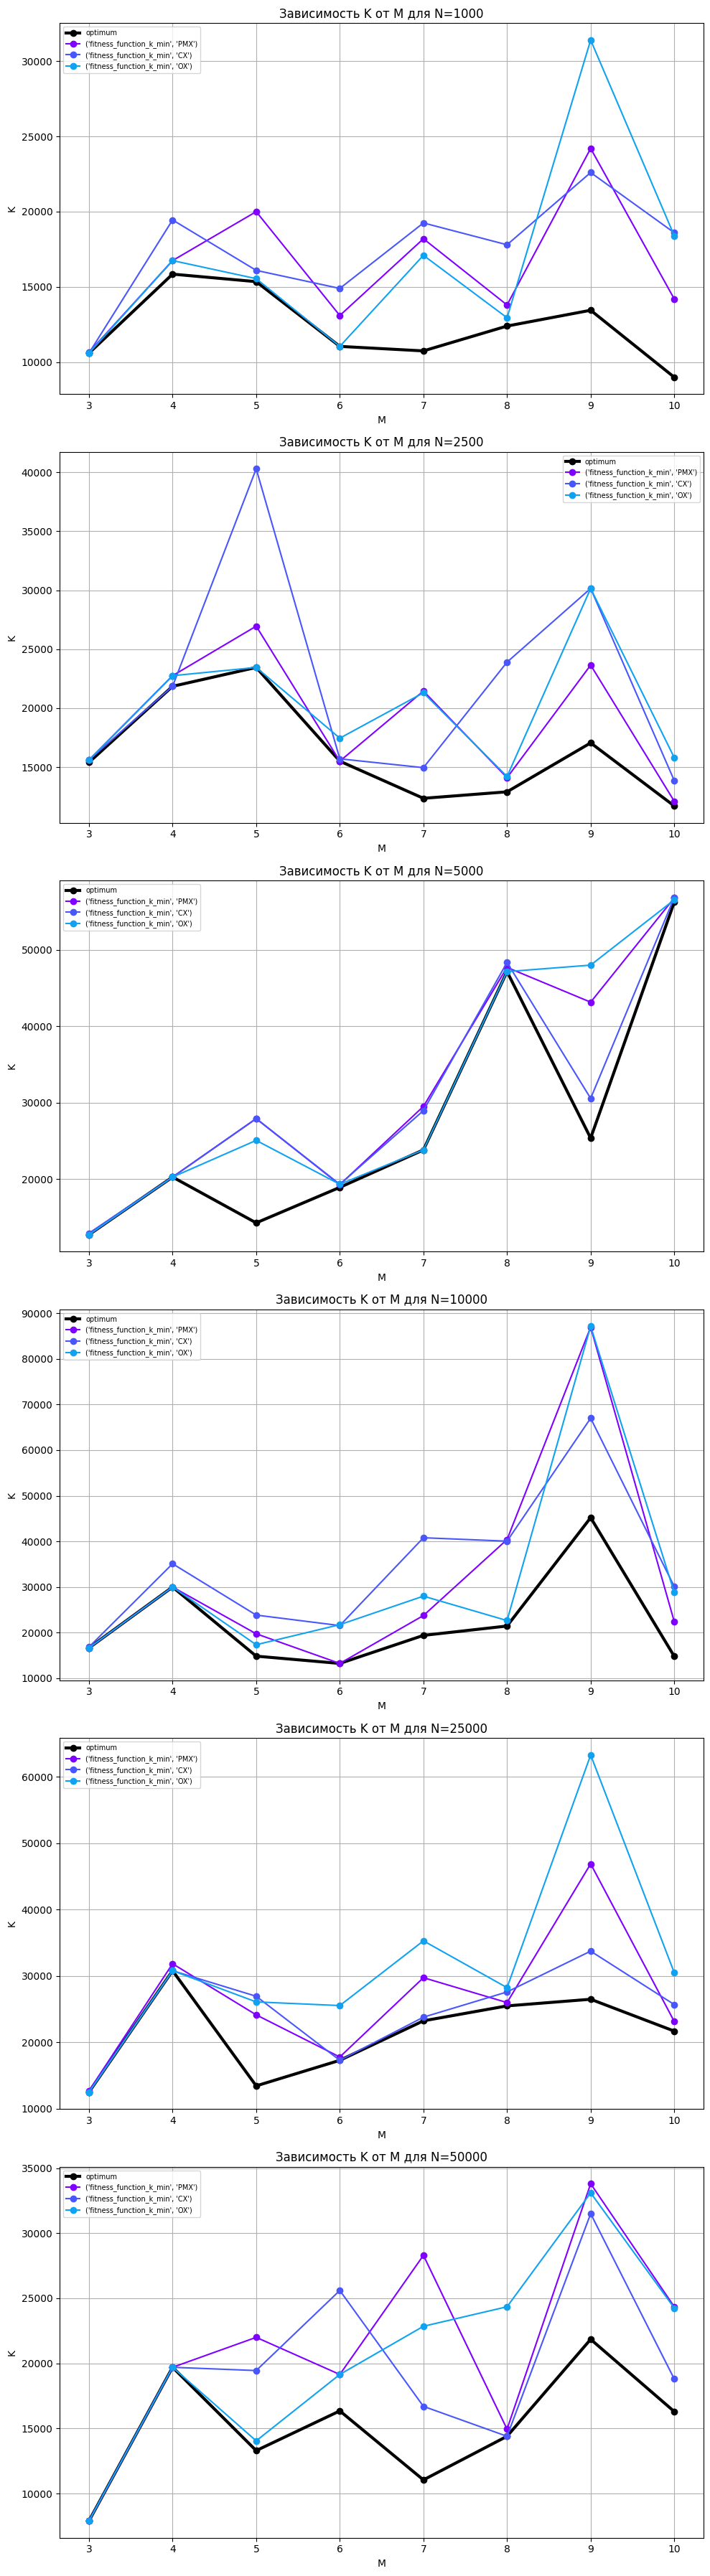

In [20]:
# Построение графиков для всех N
fig, axs = plt.subplots(len(res), figsize=(10, 6 * len(res)))

if len(res) == 1:  # Если в res только одно значение N, преобразуем axs в список
    axs = [axs]

for ax, (N, strategies) in zip(axs, res.items()):
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, 9 + 1)))
    for key, data in strategies.items():
        M = data['M']
        K = data['K']
        if key[0] == "random":
            label = "optimum"
            ax.plot(M, K, marker='o', linestyle='-', label=label, color="black", linewidth=3)
        else:
            label = key[0].__name__, key[1].__name__
            ax.plot(M, K, marker='o', linestyle='-', color=next(colors), label=label)
    
    ax.set_title(f'Зависимость K от M для N={N}')
    ax.set_xlabel('M')
    ax.set_ylabel('K')
    ax.legend(loc=0, prop={'size': 7})
    ax.grid(True)

plt.tight_layout()
plt.show()


In [15]:
# for N, strategies in res.items():
#     fig, ax = plt.subplots(figsize=(10, 6))
#     for key, data in strategies.items():
#         M = data['M']
#         K = data['K']
#         label = str(key)
#         ax.plot(M, K, marker='o', linestyle='-', label=label)
    
#     ax.set_title(f'Зависимость K от M для N={N}')
#     ax.set_xlabel('M')
#     ax.set_ylabel('K')
#     ax.legend(loc=0, prop={'size': 7})
#     ax.grid(True)

#     base_path = f"./res/{N}"

#     fig.savefig(f"{base_path}.svg")
#     fig.savefig(f"{base_path}.eps", format='eps')
#     fig.savefig(f"{base_path}.jpg")

#     plt.close(fig)


'PMX'

In [61]:
# mmm = defaultdict(list)
# for N in res:
#     for alg in res[N]:
#         for M, K in zip(res[N][alg]["M"], res[N][alg]["K"]):
#             if alg[0] == "random":
#                 mmm[(N, M)].append((K, "optimum"))
#             else:
#                 mmm[(N, M)].append((K,  alg[0]))
mmm = defaultdict(list)
for N in res:
    for key in res[N]:
        for M, K in zip(res[N][alg]["M"], res[N][alg]["K"]):
            if key[0] == "optimum":
                label = key[0] + " | " + str(key[1])
                continue
            else:
                label = key[0] + " | " + key[1][0] + " | " + key[1][1]

            mmm[(N, M)].append((K, label))


In [62]:
alg_map = defaultdict(int)
for case in mmm:
    mmm[case].sort(key=lambda x: x[0])
    tmp = mmm[case][0]
    i = 1
    for v in mmm[case]:
        if v != tmp:
            i += 1
            tmp = v
        alg_map[v[1]] += i

In [63]:
alg_map

defaultdict(int,
            {'METIS | MAGNA++ | fitness_function_degree, PMX': 80,
             'METIS | MAGNA++ | fitness_function_k_min, PMX': 160,
             'METIS | ISORANK | $\\alpha$ = 0.05': 240,
             'METIS | ISORANK | $\\alpha$ = 0.1': 320,
             'CTCEHC (weight = bw) | MAGNA++ | fitness_function_degree, PMX': 320,
             'CTCEHC (weight = bw) | MAGNA++ | fitness_function_k_min, PMX': 384,
             'CTCEHC (weight = bw) | ISORANK | $\\alpha$ = 0.05': 448,
             'CTCEHC (weight = bw) | ISORANK | $\\alpha$ = 0.1': 512})

In [64]:
x = sorted(alg_map.items(), key=lambda x: x[1])

In [65]:
df = pd.DataFrame(x, columns=["params", "Score"])

In [66]:
df

,params,Score
0,"METIS | MAGNA++ | fitness_function_degree, PMX",80
1,"METIS | MAGNA++ | fitness_function_k_min, PMX",160
2,METIS | ISORANK | $\alpha$ = 0.05,240
3,METIS | ISORANK | $\alpha$ = 0.1,320
4,CTCEHC (weight = bw) | MAGNA++ | fitness_funct...,320
5,CTCEHC (weight = bw) | MAGNA++ | fitness_funct...,384
6,CTCEHC (weight = bw) | ISORANK | $\alpha$ = 0.05,448
7,CTCEHC (weight = bw) | ISORANK | $\alpha$ = 0.1,512


In [23]:
magna_params = {
    "fit": [fitness_function_degree, fitness_function_k_min, fitness_function_diff_loss],
    # "fit": [fitness_function_k_min],
    "cros": [PMX, CX, OX]
}

In [24]:
res = {}
for G in tqdm(topos):
    for S in tqdm(servers):
        T = TopoGraph(G)
        labels, time = T.split_graph(len(S), part_graph=metis.part_graph)
        cluster = T.get_cluster_graph()

        best_map, *_ = matching_graphs(cluster, S, match=matcher["random"])
        best_K_min = K_MIN(cluster, S, best_map)
        
        N = len(G)
        M = len(S)
        
        if N not in res:
            res[N] = {}
            res[N][("random", "best")] = {"M": [], "K": []}

        res[N][("random", "best")]["M"].append(M)
        res[N][("random", "best")]["K"].append(best_K_min)
        
        for fit in magna_params["fit"]:
            for cros in magna_params["cros"]:
                params = {
                    "fit": fit,
                    "cros": cros
                }
                mapping, *_ = matching_graphs(cluster, S, match=matcher["magna++"], params=params)
                K_min = K_MIN(cluster, S, mapping)

                if (fit, cros) not in res[N]:
                    res[N][(fit, cros)] = {"M": [], "K": []}

                res[N][(fit, cros)]["M"].append(M)
                res[N][(fit, cros)]["K"].append(K_min)

                
                

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [8]:
isorank_params = {
    "alpha": [0.05, 0.10],
    "num_iterations": [100]
}
magna_params = {
    "fit": [fitness_function_degree, fitness_function_k_min],
    "cros": [PMX]
}
clusters = {
    "alg": [metis.part_graph, CTCEHC_part]
}

In [9]:
T = TopoGraph(topos[0])
labels, time = T.split_graph(4, part_graph=CTCEHC_part)

In [11]:
Counter(labels), time

(Counter({2: 600, 0: 165, 3: 128, 1: 107}), 3.665091037750244)

In [12]:
T = TopoGraph(topos_neg[0])
labels, time = T.split_graph(4, part_graph=CTCEHC_part)

In [13]:
Counter(labels), time

(Counter({3: 310, 0: 249, 1: 223, 2: 218}), 3.401313304901123)

In [14]:
CV(1000, 4, labels)

0.14634206503941374

In [9]:
gen_pos = []
gen_neg = []

for size in range(100, 1001, 100):
    G, G_neg = gen_cg(size, 0.13)
    gen_pos.append(G)
    gen_neg.append(G_neg)


In [27]:
met = {}
pos = {}
neg = {}

def reneg_bw(G: nx.Graph):
    for u, v in G.edges:
        G[u][v]["bw"] = int(1/G[u][v]["bw"])
    return G

for G, G_neg in tqdm(zip(gen_pos, gen_neg)):
    for S in servers:
        N = len(G)
        M = len(S)

        T = TopoGraph(G)
        labels, _ = T.split_graph(M, part_graph=metis.part_graph)
        if len(S) != len(T.get_cluster_graph()):
            continue
        met[(G, S)] = (labels, T.get_cluster_graph(), S)

        labels, _ = T.split_graph(M, part_graph=CTCEHC_part)
        if len(S) != len(T.get_cluster_graph()):
            continue
        pos[(G, S)] = (labels, T.get_cluster_graph(), S)
        
        T_neg = TopoGraph(G_neg)
        labels, _ = T_neg.split_graph(M, part_graph=CTCEHC_part)
        if len(S) != len(T_neg.get_cluster_graph()):
            continue
        neg[(G_neg, S)] = (labels, reneg_bw(T_neg.get_cluster_graph()), S)
        

0it [00:00, ?it/s]

In [28]:
res_1 = defaultdict(list)
for G, S in met:
    res_1[len(G)].append(CV(len(G), len(S), met[(G,S)][0]))
met_res = {"N": [], "K_SIZE": []}
for n in res_1:
    met_res["N"].append(n)
    met_res["K_SIZE"].append(np.mean(res_1[n]))

res_2 = defaultdict(list)
for G, S in pos:
    res_2[len(G)].append(CV(len(G), len(S), pos[(G,S)][0]))
pos_res = {"N": [], "K_SIZE": []}
for n in res_2:
    pos_res["N"].append(n)
    pos_res["K_SIZE"].append(np.mean(res_2[n]))

res_3 = defaultdict(list)
for G, S in neg:
    res_3[len(G)].append(CV(len(G), len(S), neg[(G,S)][0]))
    
neg_res = {"N": [], "K_SIZE": []}
for n in res_3:
    neg_res["N"].append(n)
    neg_res["K_SIZE"].append(np.mean(res_3[n]))

In [46]:
neg_res

{'N': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'K_SIZE': [0.019559448793008687,
  0.01961120012828412,
  0.020492743945414643,
  0.024453990609198104,
  0.02216356911270794,
  0.02470452302329002,
  0.02661475661786471,
  0.025129618247669277,
  0.024521838541297875,
  0.02392079348756885]}

In [51]:
met_res

{'N': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'K_SIZE': [0.019559448793008687,
  0.01961120012828412,
  0.020492743945414643,
  0.024453990609198104,
  0.02216356911270794,
  0.02470452302329002,
  0.02661475661786471,
  0.025129618247669277,
  0.024521838541297875,
  0.02392079348756885]}

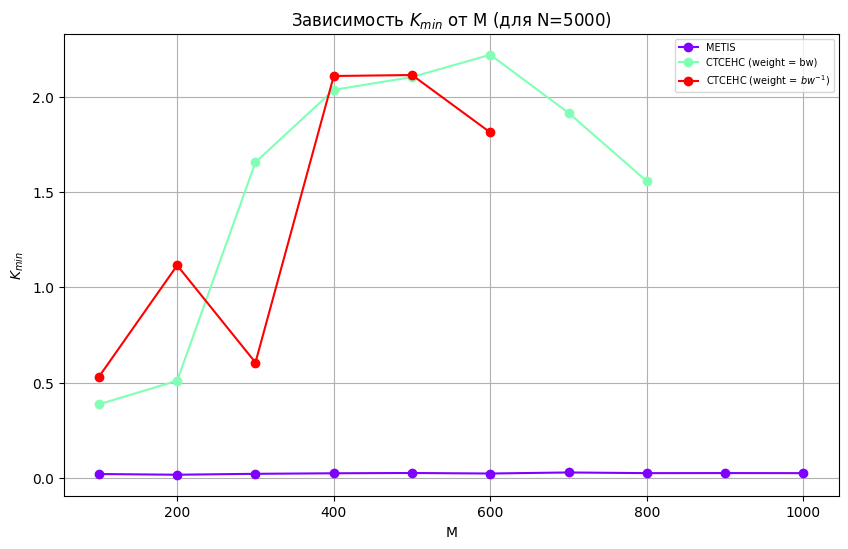

In [29]:
# Построение графиков
fig, ax = plt.subplots(figsize=(10, 6))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, 3)))

for label, data in [("METIS", met_res), ("CTCEHC (weight = bw)", pos_res), (r"CTCEHC (weight = $bw^{-1}$)", neg_res)]:
    M = data['N']
    K = data['K_SIZE']
    ax.plot(M, K, marker='o', linestyle='-', color=next(colors), label=label)

ax.set_title(r'Зависимость $K_{min}$ от M (для N=5000)')
ax.set_xlabel('M')
ax.set_ylabel(r"$K_{min}$")
ax.legend(loc=0, prop={'size': 7})
ax.grid(True)
base_path = f"./res/gen{5000}"
plt.show()
# fig.savefig(f"{base_path}.svg")
# fig.savefig(f"{base_path}.eps", format='eps')
# fig.savefig(f"{base_path}.jpg")
# plt.close()


In [32]:
res = {}
matcher = {
    "random": random_matching,
    "isorank": isorank,
    "netal":  netal_enhanced,
    "magna++": magna_plus_plus
}
for label, data in [("METIS", met), ("CTCEHC (weight = bw)", pos)]:
    for G, S in tqdm(data):
        _, cluster, S = data[(G, S)]
        

        best_map, *_ = matching_graphs(cluster, S, match=matcher["random"])
        best_K_min = K_MIN(cluster, S, best_map)
        
        N = len(G)
        M = len(S)
        
        if N not in res:
            res[N] = {}
            res[N][("optimum", "METIS")] = {"M": [], "K": []}
            res[N][("optimum", "CTCEHC (weight = bw)")] = {"M": [], "K": []}
            res[N][("optimum", r"CTCEHC (weight = $bw^{-1}$)")] = {"M": [], "K": []}
    
        res[N][("optimum", label)]["M"].append(M)
        res[N][("optimum", label)]["K"].append(best_K_min)
        
        for fit in magna_params["fit"]:
            for cros in magna_params["cros"]:
                params = {
                    "fit": fit,
                    "cros": cros
                }
                mapping, *_ = matching_graphs(cluster, S, match=matcher["magna++"], params=params)
                K_min = K_MIN(cluster, S, mapping)
    
                if (label, ("MAGNA++", fit.__name__ + ", " + cros.__name__)) not in res[N]:
                    res[N][(label, ("MAGNA++", fit.__name__ + ", " + cros.__name__))] = {"M": [], "K": []}
    
                res[N][(label, ("MAGNA++", fit.__name__ + ", " + cros.__name__))]["M"].append(M)
                res[N][(label, ("MAGNA++", fit.__name__ + ", " + cros.__name__))]["K"].append(K_min)
                
        for alpha in isorank_params["alpha"]:
                for num_iters in isorank_params["num_iterations"]:
                    params = {
                        "alpha": alpha,
                        "num_iterations": num_iters
                    }
                    mapping, *_ = matching_graphs(cluster, S, match=matcher["isorank"], params=params)
                    K_min = K_MIN(cluster, S, mapping)
    
                    if (label, ("ISORANK", r"$\alpha$ = "f"{alpha}")) not in res[N]:
                        res[N][(label, ("ISORANK", r"$\alpha$ = "f"{alpha}"))] = {"M": [], "K": []}
    
                    res[N][(label, ("ISORANK", r"$\alpha$ = "f"{alpha}"))]["M"].append(M)
                    res[N][(label, ("ISORANK", r"$\alpha$ = "f"{alpha}"))]["K"].append(K_min)

                
                

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [35]:
for n in res:
    del res[n][("optimum", r"CTCEHC (weight = $bw^{-1}$)")]

KeyError: ('optimum', 'CTCEHC (weight = $bw^{-1}$)')

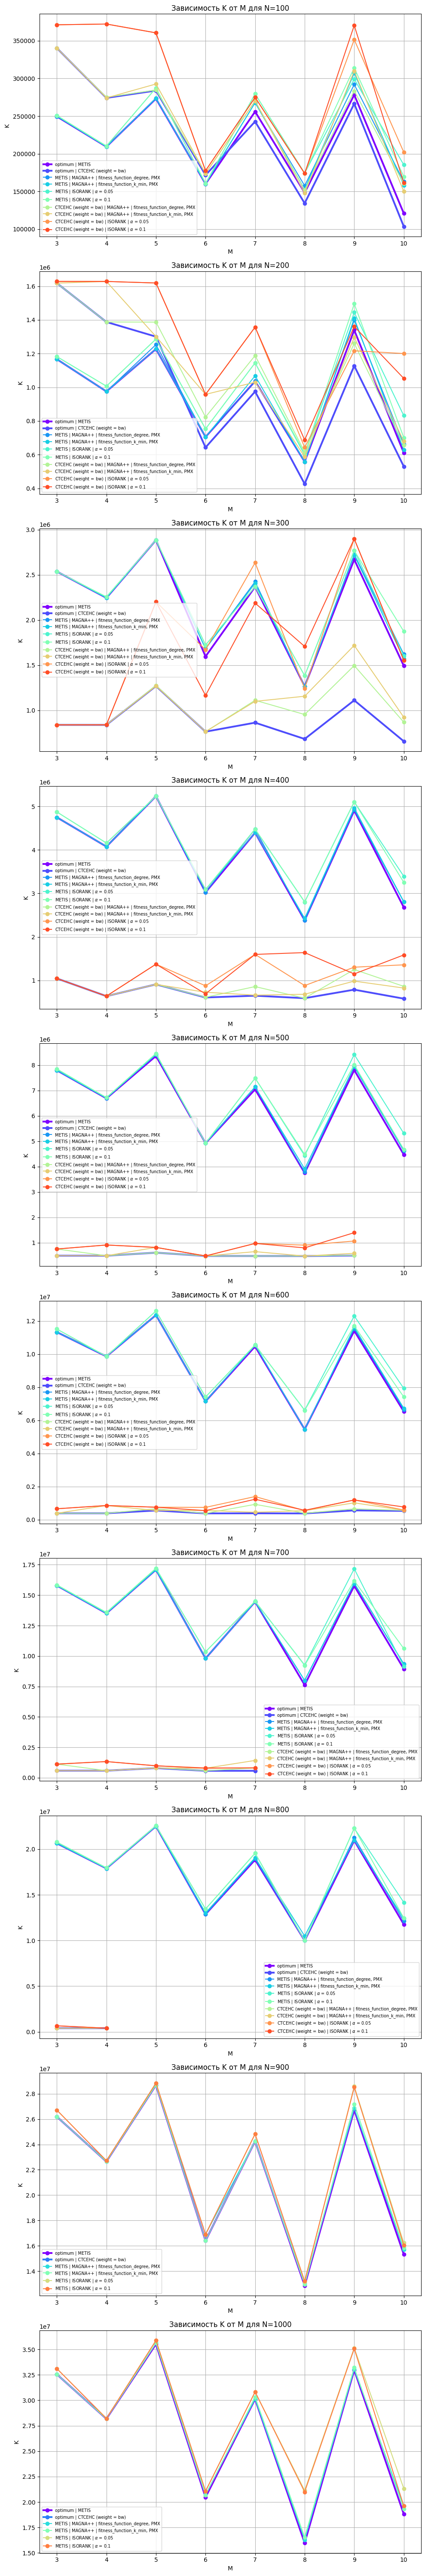

In [36]:
# Построение графиков для всех N
fig, axs = plt.subplots(len(res), figsize=(10, 6 * len(res)))

if len(res) == 1:  # Если в res только одно значение N, преобразуем axs в список
    axs = [axs]

for ax, (N, strategies) in zip(axs, res.items()):
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(strategies) + 1)))
    for key, data in strategies.items():
        M = data['M']
        K = data['K']
        if key[0] == "optimum":
            label = key[0] + " | " + str(key[1])
            ax.plot(M, K, marker='o', linestyle='-', label=label, color=next(colors), linewidth=3)
        else:
            label = key[0] + " | " + key[1][0] + " | " + key[1][1]
            ax.plot(M, K, marker='o', linestyle='-', color=next(colors), label=label)
    
    ax.set_title(f'Зависимость K от M для N={N}')
    ax.set_xlabel('M')
    ax.set_ylabel('K')
    ax.legend(loc=0, prop={'size': 7})
    ax.grid(True)

plt.tight_layout()
plt.show()


In [74]:
# Построение графиков
fig, ax = plt.subplots(figsize=(10, 6))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(res))))
# Перебор всех ключей и значений в словаре
for key, data in res[100].items():
    M = data['M']
    K = data['K']
    if key[0] == "optimum":
        label = key[0] + " | " + str(key[1])
        ax.plot(M, K, marker='o', linestyle='-', label=label, color=next(colors), linewidth=3)
    else:
        label = key[0] + " | " + key[1][0] + " | " + key[1][1]
        ax.plot(M, K, marker='o', linestyle='-', color=next(colors), label=label)

ax.set_title(r'Зависимость $K_{min}$ от M (для N=1000)')
ax.set_xlabel('M')
ax.set_ylabel(r"$K_{min}$")
ax.legend(loc=1, prop={'size': 7})
ax.grid(True)
base_path = f"./res/metctc{1000}"
# plt.show()
fig.savefig(f"{base_path}.svg")
fig.savefig(f"{base_path}.eps", format='eps')
fig.savefig(f"{base_path}.jpg")
plt.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
magna_params = {
    "fitness": {
        r"$K_{min}$": fitness_function_k_min,
        r"$K_{degree}$": fitness_function_degree
    },
    "crossover": {name: Crossover.__dict__[name] for name in Crossover.__dict__ if not name.startswith("_")}
}

In [16]:
met = {}

for G in topos:
    for S in servers:
        N = len(G)
        M = len(S)

        T = TopoGraph(G)
        labels, _ = T.split_graph(M, part_graph=metis.part_graph)
        if len(S) != len(T.get_cluster_graph()):
            continue
        met[(N, M)] = (T.get_cluster_graph(), S)

In [33]:
res = {}

for N, M in tqdm(met):
    if M < 5:
        continue
    C, S = met[(N, M)]
    best_map, *_ = matching_graphs(C, S, match=matcher["random"])
    best_K_min = K_MIN(C, S, best_map)
    
    if N not in res:
        res[N] = {}
        res[N][("optimum")] = {"M": [], "K": []}

    res[N][("optimum")]["M"].append(M)
    res[N][("optimum")]["K"].append(best_K_min)
    
    for fit_name, fit in tqdm(magna_params["fitness"].items()):
        for cros_name, cros in magna_params["crossover"].items():
            params = {
                "fitness": fit,
                "crossover": cros
            }
            mapping, *_ = magna_plus_plus(C, S, fitness=fit, crossover=cros, population_size=50, generations=500)
            K_min = K_MIN(C, S, mapping)

            if ("MAGNA++", fit_name + ", " + cros_name) not in res[N]:
                res[N][("MAGNA++", fit_name + ", " + cros_name)] = {"M": [], "K": []}

            res[N][("MAGNA++", fit_name + ", " + cros_name)]["M"].append(M)
            res[N][("MAGNA++", fit_name + ", " + cros_name)]["K"].append(K_min)


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [40]:
# Построение графиков для всех N
fig, axs = plt.subplots(len(res), figsize=(10, 6 * len(res)))

if len(res) == 1:  # Если в res только одно значение N, преобразуем axs в список
    axs = [axs]

for ax, (N, strategies) in zip(axs, res.items()):
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(strategies) + 1)))
    for key, data in strategies.items():
        M = data['M']
        K = data['K']
        if key == "optimum":
            label = key
            ax.plot(M, K, marker='o', linestyle='-', label=label, color="black", linewidth=5)
        else:
            label = key
            ax.plot(M, K, marker='o', linestyle='-', color=next(colors), label=label)
    
    ax.set_title(f'Зависимость K от M для N={N}')
    ax.set_xlabel('M')
    ax.set_ylabel('K')
    ax.legend(loc=0, prop={'size': 7})
    ax.grid(True)
plt.tight_layout()
base_path = f"./res/123/{N}-magna"
fig.savefig(f"{base_path}.svg")
fig.savefig(f"{base_path}.eps", format='eps')
fig.savefig(f"{base_path}.jpg")
plt.close()
# plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [44]:
mmm = defaultdict(list)
for N in res:
    for key in res[N]:
        for M, K in zip(res[N][key]["M"], res[N][key]["K"]):
            if key == "optimum":
                label = key
                continue
            else:
                label = key
    
            mmm[(N, M)].append((K, label))

alg_map = defaultdict(int)
for case in mmm:
    mmm[case].sort(key=lambda x: x[0])
    tmp = mmm[case][0]
    i = 1
    for v in mmm[case]:
        if v != tmp:
            i += 1
            tmp = v
        alg_map[v[1]] += i

x = sorted(alg_map.items(), key=lambda x: x[1])
df = pd.DataFrame(x, columns=["params", "Score"])

In [45]:
df

,params,Score
0,"(MAGNA++, $K_{min}$, PMX)",105
1,"(MAGNA++, $K_{min}$, CX)",133
2,"(MAGNA++, $K_{min}$, MOC)",136
3,"(MAGNA++, $K_{min}$, OX)",149
4,"(MAGNA++, $K_{min}$, MPMX)",191
5,"(MAGNA++, $K_{min}$, OBX)",220
6,"(MAGNA++, $K_{min}$, POS)",221
7,"(MAGNA++, $K_{min}$, MPX)",265
8,"(MAGNA++, $K_{min}$, PX)",292
9,"(MAGNA++, $K_{min}$, ER)",337


In [37]:
res[1000]

{'optimum': {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 10750.0, 12400.0, 12550.0, 9000.0]},
 ('MAGNA++', '$K_{min}$, PMX'): {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 14500.0, 13050.0, 13450.0, 9600.0]},
 ('MAGNA++', '$K_{min}$, CX'): {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 10750.0, 12900.0, 12550.0, 9250.0]},
 ('MAGNA++', '$K_{min}$, OX'): {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 10750.0, 13050.0, 18650.0, 9600.0]},
 ('MAGNA++', '$K_{min}$, MOC'): {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 10750.0, 12400.0, 12550.0, 9100.0]},
 ('MAGNA++', '$K_{min}$, MPMX'): {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 10750.0, 12900.0, 18450.0, 9600.0]},
 ('MAGNA++', '$K_{min}$, OBX'): {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 10750.0, 12400.0, 12550.0, 9600.0]},
 ('MAGNA++', '$K_{min}$, POS'): {'M': [5, 6, 7, 8, 9, 10],
  'K': [15350.0, 11050.0, 10750.0, 12400.0, 12550.0, 9100.0]},
 ('MAGNA++', '$K_{min}$, VR'): {'M': [5, 6, 7